In [ ]:
# Импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
from sqlalchemy import create_engine

from dotenv import load_dotenv
from catboost import CatBoostClassifier
import os
import gc

In [ ]:
# Загружаем переменные окружения из .env файла
load_dotenv()

In [ ]:
# Создаем URL для SQLAlchemy
SQLALCHEMY_DATABASE_URL = (
    f"postgresql://"
    f"{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@"
    f"{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/"
    f"{os.getenv('POSTGRES_DATABASE')}"
)
engine = create_engine(SQLALCHEMY_DATABASE_URL)

In [4]:
### Данные по пользователям с нашими признаками

user_info = pd.read_sql(
    """SELECT * FROM users_info_features_ruslan_prashchurovich""", con=engine
)

user_info.head()

,user_id,gender,country,city,exp_group,os,source,age_category,user_total_views,user_total_likes,user_ctr,favorite_topic,favorite_hour,mean_length_view,mean_length_number_view,mean_length_like,mean_length_number_like
0,200,1,Russia,Degtyarsk,3,Android,ads,young,315,43,0.120112,entertainment,8,1798.600000,8.133333,1439.400000,5.200000
1,201,0,Russia,Abakan,0,Android,ads,middle_aged,632,58,0.084058,tech,22,1636.866667,3.800000,1984.266667,3.666667
2,202,1,Russia,Smolensk,4,Android,ads,child,541,87,0.138535,politics,22,449.266667,3.133333,1095.600000,3.600000
3,203,0,Russia,Moscow,1,iOS,ads,young,258,61,0.191223,sport,16,1053.800000,2.933333,1898.333333,4.800000
4,204,0,Russia,Anzhero-Sudzhensk,3,Android,ads,middle_aged,115,23,0.166667,tech,15,1441.266667,4.333333,1104.066667,4.600000


In [5]:
### Посты и топики с нашими признаками

posts_info = pd.read_sql(
    """SELECT * FROM posts_info_features_ruslan_prashchurovich""", con=engine
)

posts_info.head()

,post_id,text,topic,numbers_count,text_length,word_count,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,...,DistanceTo19thCluster,DistanceTo20thCluster,DistanceTo21thCluster,DistanceTo22thCluster,DistanceTo23thCluster,DistanceTo24thCluster,DistanceTo25thCluster,total_views_post,total_likes_post,post_ctr
0,1,UK economy facing major risks\n\nThe UK manufa...,business,13,1967,327,8.134297,0.511790,0.000541,8,...,0.611784,0.581796,0.584506,0.587526,0.540042,0.624294,0.702854,7414,1057,0.142568
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,20,2701,449,11.356141,0.254945,0.000756,22,...,0.587971,0.557299,0.577983,0.579828,0.512105,0.646764,0.703910,6851,636,0.092833
2,3,Asian quake hits European shares\n\nShares in ...,business,47,3408,571,10.911138,0.410319,0.000726,8,...,0.668490,0.658415,0.700094,0.685362,0.642903,0.629109,0.773713,7263,1116,0.153656
3,4,India power shares jump on debut\n\nShares in ...,business,6,1026,178,6.754817,0.372043,0.000450,8,...,0.716179,0.683872,0.682313,0.680886,0.633085,0.789145,0.804049,6964,1165,0.167289
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3,889,155,5.946105,0.526337,0.000396,22,...,0.554863,0.506563,0.484730,0.524628,0.448073,0.686375,0.635861,7400,1141,0.154189


In [6]:
### Попробуем обучить, скажем, на 5 миллионах строк (таблица слишком большая: более 70 млн строк)

feed_data = pd.read_sql(
    """SELECT * FROM feed_data WHERE action = 'view' LIMIT 5000000""", con=engine
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-10 14:55:08,84681,1338,view,1
1,2021-12-10 14:57:33,84681,6282,view,0
2,2021-12-10 14:58:52,84681,4553,view,0
3,2021-12-10 15:01:41,84681,3214,view,0
4,2021-12-10 15:03:50,84681,4360,view,0


In [8]:
### Воспроизведем датафрейм со всеми новыми фичами
df = pd.merge(feed_data, posts_info, on="post_id", how="left")
df = pd.merge(df, user_info, on="user_id", how="left")

df.head()

,timestamp,user_id,post_id,action,target,text,topic,numbers_count,text_length,word_count,...,age_category,user_total_views,user_total_likes,user_ctr,favorite_topic,favorite_hour,mean_length_view,mean_length_number_view,mean_length_like,mean_length_number_like
0,2021-12-10 14:55:08,84681,1338,view,1,Iraq advice claim sparks new row\n\nThe Tories...,politics,14,3600,609,...,young,396,65,0.140998,sport,11,912.466667,3.066667,1725.466667,5.866667
1,2021-12-10 14:57:33,84681,6282,view,0,Little Dieter Needs To Fly is another in the r...,movie,4,2428,445,...,young,396,65,0.140998,sport,11,912.466667,3.066667,1725.466667,5.866667
2,2021-12-10 14:58:52,84681,4553,view,0,There is only one film I can think of that mig...,movie,0,1086,205,...,young,396,65,0.140998,sport,11,912.466667,3.066667,1725.466667,5.866667
3,2021-12-10 15:01:41,84681,3214,view,0,#goodnotes this brings home that there are s...,covid,4,140,23,...,young,396,65,0.140998,sport,11,912.466667,3.066667,1725.466667,5.866667
4,2021-12-10 15:03:50,84681,4360,view,0,If this is the authors and directors idea of a...,movie,0,869,149,...,young,396,65,0.140998,sport,11,912.466667,3.066667,1725.466667,5.866667


In [9]:
### А еще научимся выделять признаки из даты
df["hour"] = pd.to_datetime(df["timestamp"]).apply(lambda x: x.hour)
df["month"] = pd.to_datetime(df["timestamp"]).apply(lambda x: x.month)

# Циклическое кодирование
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,numbers_count,text_length,word_count,...,mean_length_view,mean_length_number_view,mean_length_like,mean_length_number_like,hour,month,hour_sin,hour_cos,month_sin,month_cos
0,2021-12-10 14:55:08,84681,1338,view,1,Iraq advice claim sparks new row\n\nThe Tories...,politics,14,3600,609,...,912.466667,3.066667,1725.466667,5.866667,14,12,-0.500000,-0.866025,-2.449294e-16,1.0
1,2021-12-10 14:57:33,84681,6282,view,0,Little Dieter Needs To Fly is another in the r...,movie,4,2428,445,...,912.466667,3.066667,1725.466667,5.866667,14,12,-0.500000,-0.866025,-2.449294e-16,1.0
2,2021-12-10 14:58:52,84681,4553,view,0,There is only one film I can think of that mig...,movie,0,1086,205,...,912.466667,3.066667,1725.466667,5.866667,14,12,-0.500000,-0.866025,-2.449294e-16,1.0
3,2021-12-10 15:01:41,84681,3214,view,0,#goodnotes this brings home that there are s...,covid,4,140,23,...,912.466667,3.066667,1725.466667,5.866667,15,12,-0.707107,-0.707107,-2.449294e-16,1.0
4,2021-12-10 15:03:50,84681,4360,view,0,If this is the authors and directors idea of a...,movie,0,869,149,...,912.466667,3.066667,1725.466667,5.866667,15,12,-0.707107,-0.707107,-2.449294e-16,1.0


In [10]:
### Уберем все ненужные колонки

df = df.drop(
    columns=[
        #    'timestamp',  ### timestamp пока оставим
        "action",
        "text",
    ],
    axis=1,
)

In [11]:
# Почистим переменные

del user_info
del posts_info
del feed_data

gc.collect()

0

In [12]:
### За отсечку возьмем 2021-12-10

X_train = df[df.timestamp < "2021-12-10"].drop(
    columns=["timestamp", "target", "user_id", "post_id"], axis=1
)
X_test = df[df.timestamp >= "2021-12-10"].drop(
    columns=["timestamp", "target", "user_id", "post_id"], axis=1
)

y_train = df[df.timestamp < "2021-12-10"]["target"]
y_test = df[df.timestamp >= "2021-12-10"]["target"]

y_train.shape, y_test.shape

((3875355,), (1124645,))

In [13]:
object_cols = [
    "topic",
    "TextCluster",
    "gender",
    "country",
    "city",
    "exp_group",
    "hour",
    "month",
    "favorite_topic",
    "os",
    "source",
    "age_category",
    "favorite_hour",
]

In [17]:
### Теперь обучим катбуст!

seed = 104773
catboost = CatBoostClassifier(
    iterations=150,
    learning_rate=1,
    depth=5,
    cat_features=object_cols,
    verbose=0,
    random_state=seed,
)

catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=25)

0:	learn: 0.3480067	test: 0.3930940	best: 0.3930940 (0)	total: 2.23s	remaining: 5m 31s
25:	learn: 0.3372880	test: 0.3823317	best: 0.3823317 (25)	total: 49.1s	remaining: 3m 54s
50:	learn: 0.3359490	test: 0.3806361	best: 0.3806361 (50)	total: 1m 35s	remaining: 3m 5s
75:	learn: 0.3352086	test: 0.3803387	best: 0.3803387 (75)	total: 2m 21s	remaining: 2m 18s
100:	learn: 0.3345435	test: 0.3795612	best: 0.3795612 (100)	total: 3m 7s	remaining: 1m 31s
125:	learn: 0.3339486	test: 0.3791217	best: 0.3791173 (121)	total: 3m 55s	remaining: 44.8s
149:	learn: 0.3335277	test: 0.3790315	best: 0.3789989 (147)	total: 4m 40s	remaining: 0us

bestTest = 0.3789989306
bestIteration = 147

Shrink model to first 148 iterations.


In [19]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC
from sklearn.metrics import roc_auc_score

print(
    f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}"
)
print(
    f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}"
)

Качество на трейне: 0.6874009321752084
Качество на тесте: 0.6657179614328319


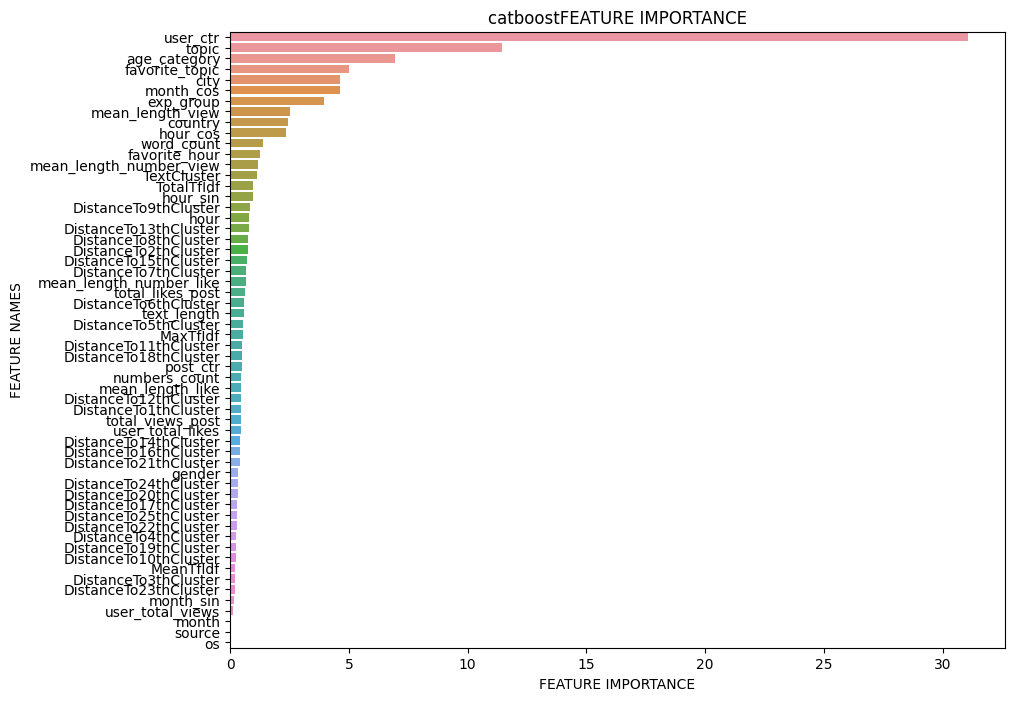

In [ ]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def plot_feature_importance(importance, names, model_type):

    # Создадим массивы важности и названий признаков
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Создадим датафрейм из словаря
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Отсортируем по важности
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)

    # Определим размер графика
    plt.figure(figsize=(10, 8))
    # Нарисуем
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Добавим подписи
    plt.title(model_type + "FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")


plot_feature_importance(catboost.feature_importances_, X_train.columns, "catboost")

По графику видно, что наиболее важные для модели признаки, полученные в результате feature-engineering, что безусловно, очень круто! Также, стоит отдельно отметить важность признака `age_category`, а значит, решение оставить его было правильным.


In [ ]:
### Сохраним модель
catboost.save_model("catboost_model_base", format="cbm")